# Optimizing the l1 norm with superpolyak


In [ ]:
# A pytorch compatible version of the above code.
import util
import numpy as np
import torch
import SuperPolyak

d = 5
max_elts = d
x = torch.randn(d, requires_grad=True, dtype=torch.double)

def f():
    return torch.sum(abs(x))

optimizer=SuperPolyak.SuperPolyak([x], max_elts=max_elts, eta_est=1.5)
# Closure function to allow us to call backward.
def closure():
    optimizer.zero_grad()
    loss = f()
    loss.backward()
    return loss

current_iter = 0
while closure().item() > 1e-20 and current_iter < 100:
    loss, bundle_index = optimizer.step(closure)
    print("f(y)", closure().item())
    print("Bundle index", bundle_index)
    current_iter += 1

# Optimizing a small neural network with SuperPolyak

In [ ]:
# Fitting a small neural network with pytorch.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import SuperPolyak


input_size = 100
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 2000, dtype=torch.double)
        self.fc2 = nn.Linear(2000, 1, dtype=torch.double)
        # add a convolutional layer of the appropriate __sizeof__

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # add another relu layer
        # x = F.relu(self.conv1(x))
        return x

net = Net()
# Let d be the number of parameters in net
d = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("number of parameters", d)
max_elts = int(200)
print("bundle size", max_elts)

# fake training data
x = torch.randn(1000, input_size, dtype=torch.double)
y = net(x).detach().clone().requires_grad_(False)
# Reset the parameters
net = Net()

# a loss function
def loss_function():
    return sum(torch.abs(net(x) - y))

# a closure function to allow us to call backward
max_oracle_calls = 10000
params = list(net.parameters())
linsys_solver=SuperPolyak.BundleLinearSystemSolver.LSMR
optimizer = SuperPolyak.SuperPolyak(params, max_elts=max_elts, eta_est=.1, linsys_solver=linsys_solver)
def closure():
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    return loss
gap = [closure().item()]
cumulative_oracle_calls = [0]

while closure().item() > 1e-10 and cumulative_oracle_calls[-1] < max_oracle_calls:
    loss, bundle_idx = optimizer.step(closure)
    print("Iteration: ", cumulative_oracle_calls[-1], ", Loss: ", closure().item(), ", Bundle_exit_step ", bundle_idx)
    cumulative_oracle_calls.append(bundle_idx + cumulative_oracle_calls[-1])
    gap.append(closure().item())


import matplotlib.pyplot as plt
plt.semilogy(cumulative_oracle_calls, gap)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("2 layer neural network with {} parameters".format(d))
plt.show()

# An illustration of the problems.py module

In [ ]:
import SuperPolyak
import problems
d = 100
k=2
m = 4*d*k
z = problems.MaxAffineRegressionProblem(m=m,d=100, k=k)
init = z.initializer(1)
param = [init]
optimizer = SuperPolyak.SuperPolyak(param, max_elts = 40, eta_est=2)
loss_function = z.loss()
def closure():
    optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss
gap = [closure().item()]
cumulative_oracle_calls = [0]
# A short loop that applies the SuperPolyak subgradient method to the loss function
max_oracle_calls = 1000
while closure().item() > 1e-10 and cumulative_oracle_calls[-1] < max_oracle_calls:
    loss, bundle_idx = optimizer.step(closure)
    print("Iteration: {}, Loss: {}, Bundle idx: {}".format(cumulative_oracle_calls[-1], loss, bundle_idx))
    cumulative_oracle_calls.append(bundle_idx + cumulative_oracle_calls[-1])
    gap.append(closure().item())
import matplotlib.pyplot as plt
plt.semilogy(cumulative_oracle_calls, gap)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("2 layer neural network with {} parameters".format(d))
plt.show()

# An illustration of coupling SuperPolyak with the Polyak subgradient method

In [ ]:
# Illustration of util.superpolyak_coupled_with_fallback
import SuperPolyak
import util
import problems
d = 100
k=2
m = 4*d*k
z = problems.MaxAffineRegressionProblem(m=m,d=100, k=k)
init = z.initializer(1)
param = [init]
superpolyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts = 40, eta_est=2)
polyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts = 1, eta_est=2)
loss_function = z.loss()
def closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss
gap = [closure().item()]
cumulative_oracle_calls = [0]
max_inner_iter = 10
max_outer_iter = 100
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(closure_superpolyak=closure, closure_fallback=closure, superpolyak_optimizer=superpolyak_optimizer, fallback_optimizer=polyak_optimizer, max_inner_iter=max_inner_iter, tol = 1e-10, max_outer_iter=max_outer_iter, verbose=True)
import matplotlib.pyplot as plt
plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("Max affine regression with {} parameters".format(d*2))
plt.show()

# Illustration of using the prox-gradient method as a fallback method for Lasso

SuperPolyak step accepted! Current oracle evaluations:  40 , Loss =  0.07812981015632536 , Bundle index =  40
Fallback step! Current oracle evaluations:  85 , Loss =  0.07812981015632536
SuperPolyak step accepted! Current oracle evaluations:  125 , Loss =  0.035045402881610475 , Bundle index =  40
Fallback step! Current oracle evaluations:  182 , Loss =  0.035045402881610475
SuperPolyak step accepted! Current oracle evaluations:  222 , Loss =  0.017206966979962213 , Bundle index =  40
Fallback step! Current oracle evaluations:  306 , Loss =  0.017206966979962213
SuperPolyak step accepted! Current oracle evaluations:  346 , Loss =  0.00857517312010011 , Bundle index =  40
Fallback step! Current oracle evaluations:  408 , Loss =  0.00857517312010011
SuperPolyak step accepted! Current oracle evaluations:  448 , Loss =  0.004236921605081263 , Bundle index =  40
Fallback step! Current oracle evaluations:  510 , Loss =  0.004236921605081263
SuperPolyak step accepted! Current oracle evaluatio

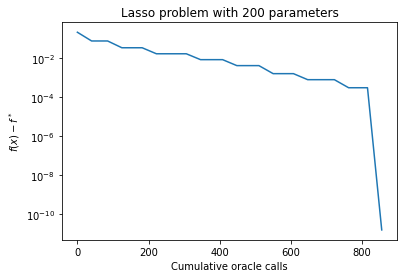

In [2]:
# Illustration of util.superpolyak_coupled_with_fallback
import SuperPolyak
import util
import problems
import proxgradient
import torch
d = 100
k=2
m = 4*k
z = problems.LassoProblem(m=m,d=d,k=k)
init = z.initializer(.00001)
param = [init]
superpolyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts = 40, eta_est=2)
proxgradient_optimizer = proxgradient.ProxGradient(param, proxs=[z.prox], lr=z.prox_step)
loss_function = z.loss()
def superpolyak_closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss
def fallback_closure():
    proxgradient_optimizer.zero_grad()
    loss = .5*torch.sum(torch.square(z.A @ init - z.y))
    loss.backward()
    return loss
max_inner_iter = 100
max_outer_iter = 100
oracle_calls, loss_list \
    = util.superpolyak_coupled_with_fallback(superpolyak_closure=superpolyak_closure,
                                             fallback_closure=fallback_closure,
                                             superpolyak_optimizer=superpolyak_optimizer,
                                             fallback_optimizer=proxgradient_optimizer,
                                             max_inner_iter=max_inner_iter,
                                             tol = 1e-10,
                                             max_outer_iter=max_outer_iter,
                                             verbose=True)
import matplotlib.pyplot as plt
plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("Lasso problem with {} parameters".format(d*2))
plt.show()

# Illustration of using the prox-gradient method as a fallback method for Lasso

Fallback step! Current oracle evaluation:  50 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  100 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  150 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  200 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  250 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  300 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  350 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  400 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  450 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  500 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  550 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  600 ,Loss =  0.01075642539586557
Fallback step! Current oracle evaluation:  650 ,Loss =  0.01075642539586557
Fallback step

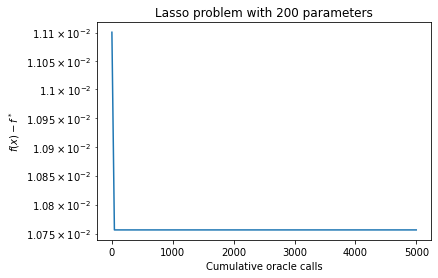

In [1]:
# Illustration of util.superpolyak_coupled_with_fallback
import SuperPolyak
import util
import problems
import proxgradient
d = 100
k=2
m = 4*k
z = problems.LassoProblem(m=m,d=d, k=k)
init = z.initializer(.01)
param = [init]
superpolyak_optimizer = SuperPolyak.SuperPolyak(param, max_elts = 40, eta_est=2)
proxgradient_optimizer = proxgradient.ProxGradient(param, proxs=[z.prox], lr=z.τ/10)
loss_function = z.loss()
def closure():
    superpolyak_optimizer.zero_grad()
    loss = loss_function(init)
    loss.backward()
    return loss
def closure_fallback():
    proxgradient_optimizer.zero_grad()
    loss = .5*torch.linalg.sum(torch.square(z.A @ init - z.y))
    loss.backward()
    return loss
gap = [closure().item()]
cumulative_oracle_calls = [0]
max_inner_iter = 10
max_outer_iter = 100
oracle_calls, loss_list = util.superpolyak_coupled_with_fallback(closure_superpolyak=closure, closure_fallback=closure, superpolyak_optimizer=superpolyak_optimizer, fallback_optimizer=proxgradient_optimizer, max_inner_iter=max_inner_iter, tol = 1e-10, max_outer_iter=max_outer_iter, verbose=True)
import matplotlib.pyplot as plt
plt.semilogy(oracle_calls, loss_list)
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
plt.title("Lasso problem with {} parameters".format(d*2))
plt.show()